In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz_analysis import get_full_statistics, named_users

/home/kavi/anaconda3/envs/urbanstats/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
plt.rcParams["font.family"] = "monospace"

In [5]:
result_full = get_full_statistics(after_problem=1, debug=False)

/home/kavi/anaconda3/envs/urbanstats/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:528: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [6]:
scores_full = result_full[["user_id", "problem", "score"]].pivot(index="user_id", columns="problem", values="score")
scores_full = scores_full[scores_full.T.count() > 10]
scores_normalized = scores_full - scores_full.sum() / scores_full.count()
scores_by_person = scores_normalized.T.mean()
counts = scores_normalized.T.count()

In [7]:
def query(*days_patterns):
    result = [
        result_full[
            (result_full.problem == day)
            & (result_full.pattern.apply(lambda x: x.tolist() == pattern))
        ].user_id
        for day, pattern in days_patterns
    ]
    result = [set(x) for x in result]
    from collections import Counter
    ctr = Counter(x for xs in result for x in xs)
    ctr = sorted(ctr.items(), key=lambda x: -x[1])
    return [(id, c - len(days_patterns), c / len(days_patterns)) for id, c in ctr]

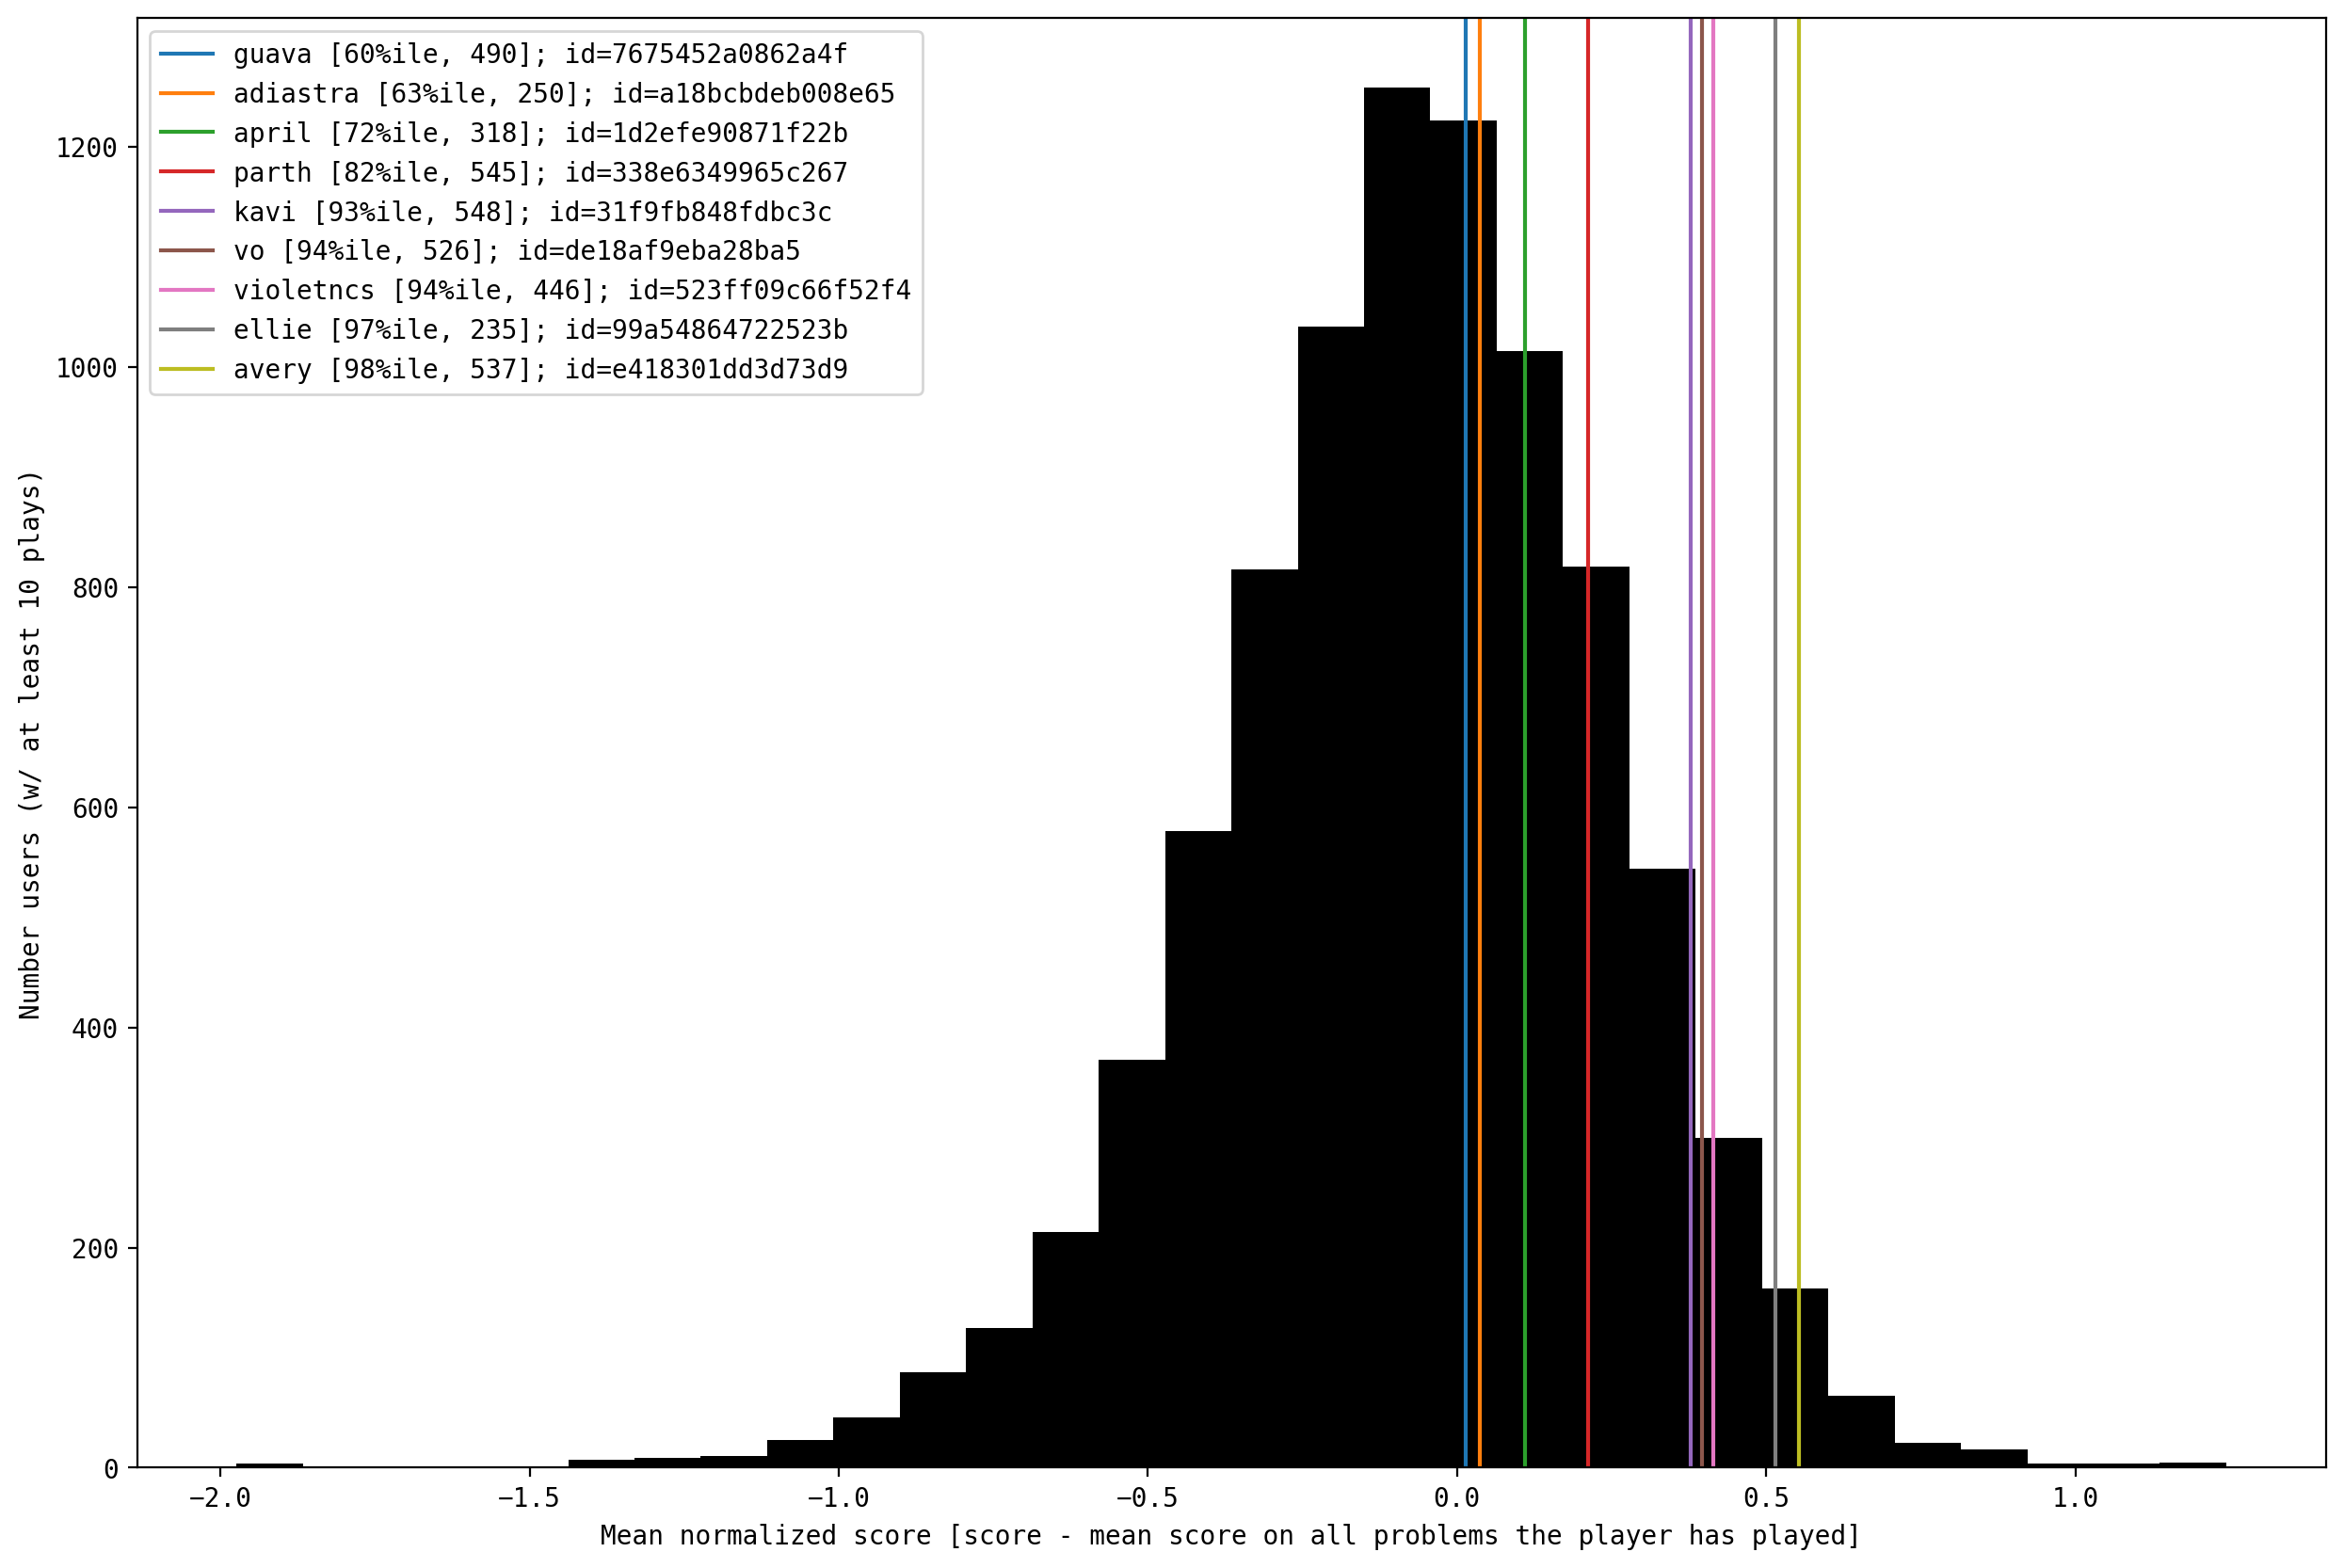

In [8]:
plt.figure(dpi=200, facecolor="white", figsize=(15, 10))
plt.hist(scores_by_person, bins=30, color="black")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
for k, color in zip(sorted(named_users, key=lambda x: scores_by_person[named_users[x]]), colors):
    plt.axvline(
        scores_by_person[named_users[k]],
        label=f"{k} [{(scores_by_person < scores_by_person[named_users[k]]).mean() * 100:.0f}%ile, {counts[named_users[k]]}]; id={hex(named_users[k])[2:]}",
        color=color,
    )
plt.xlabel("Mean normalized score [score - mean score on all problems the player has played]")
plt.ylabel("Number users (w/ at least 10 plays)")
plt.legend()
plt.show()